# Molecule Generation and Validation

The model's output is not a molecule, but rather two tensors: one for final denoised atom features and another for the 3D atomic coordinates. To get a molecule, we follow a two-step process:

1. Feature-to-Atom Conversion: We use a simple lookup table to convert the final atom feature vectors into atom types (e.g., C, N, O).
2. Coordinates-to-Bonds Conversion: We infer the bonds between atoms based on the distance between their 3D coordinates. If two atoms are a plausible distance apart, we assume there's a bond. This is a crucial, heuristic step that translates the continuous output into a discrete chemical graph.

In [1]:
import torch
import os
import logging
from rdkit import Chem
from rdkit.Chem import Descriptors
from typing import List
from pathlib import Path
import matplotlib.pyplot as plt


from mol_diff_3d.models.diffusion import MolecularDiffusionModel
from mol_diff_3d.models.noise_scheduler import NoiseScheduler
from mol_diff_3d.sampling.samplers import DDPMPsampler
from mol_diff_3d.generation.generator import generate_molecules_from_model
from mol_diff_3d.models.property_predictor import MolecularPropertyPredictor
from mol_diff_3d.utils.checkpoints import load_checkpoint
from mol_diff_3d.utils.visualization import visualize_molecule
from mol_diff_3d.utils.molecular import validate_molecule, calculate_molecular_properties
from mol_diff_3d.utils.metrics import calculate_validity_rate, calculate_uniqueness_rate, calculate_novelty_rate
from mol_diff_3d.models.gnn import E3GNN
from mol_diff_3d.data.datasets import Qm9MolecularDataset


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/jantine/miniconda3/envs/diff_gnn/lib/python3.11/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning depende

In [2]:
# Set up logging and device
logging.basicConfig(level=logging.INFO)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Paths for saving models and results
RESULTS_DIR = Path("../results/mol_diff_3d")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Define the checkpoint path within the results directory
checkpoint_path = RESULTS_DIR / "mol_diff_final.pth"

In [4]:
# Define model configuration
config = {
    'atom_dim': 11, # from previous notebook
    'pos_dim': 3,
    'hidden_dim': 128,
    'time_dim': 128,
    'num_timesteps': 1000
}

In [5]:
# Initialize model and noise scheduler
model = MolecularDiffusionModel(
    atom_dim=config['atom_dim'],
    pos_dim=config['pos_dim'],
    hidden_dim=config['hidden_dim'],
    time_dim=config['time_dim']
).to(device)
noise_scheduler = NoiseScheduler(num_timesteps=config['num_timesteps']).to(device)

# Load the checkpoint
if os.path.exists(checkpoint_path):
    checkpoint_info = load_checkpoint(checkpoint_path, model)
    print("Model successfully loaded from checkpoint.")
else:
    raise FileNotFoundError(f"Checkpoint not found at {checkpoint_path}. Please run the training notebook first.")

# Initialize the reverse sampler
p_sampler = DDPMPsampler(noise_scheduler.get_parameters())

INFO:mol_diff_3d.utils.checkpoints:Checkpoint loaded from ../results/mol_diff_3d/mol_diff_final.pth
INFO:mol_diff_3d.utils.checkpoints:Resumed from epoch 99, loss: 1.0301


Model successfully loaded from checkpoint.


In [6]:
# Set generation parameters
num_to_generate = 10
max_atoms = 25

# Generate molecules
generated_mols, generated_smiles = generate_molecules_from_model(
    model=model,
    p_sampler=p_sampler,
    num_molecules=num_to_generate,
    max_atoms=max_atoms,
    atom_dim=config['atom_dim'],
    pos_dim=config['pos_dim'],
    device=device
)

# Print generation statistics
print(f"\nAttempted to generate {num_to_generate} molecules.")
print(f"Successfully generated {len(generated_smiles)} valid molecules.")

# Calculate basic metrics
validity_rate = calculate_validity_rate(generated_smiles)
uniqueness_rate = calculate_uniqueness_rate(generated_smiles)
print(f"Validity rate: {validity_rate:.2f}")
print(f"Uniqueness rate: {uniqueness_rate:.2f}")

INFO:mol_diff_3d.generation.generator:Starting molecule generation on cuda...
INFO:mol_diff_3d.generation.generator:Generated 10 valid molecules.



Attempted to generate 10 molecules.
Successfully generated 10 valid molecules.
Validity rate: 1.00
Uniqueness rate: 0.10



--- Visualizing a few generated molecules ---
Generated Molecule 1: C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C


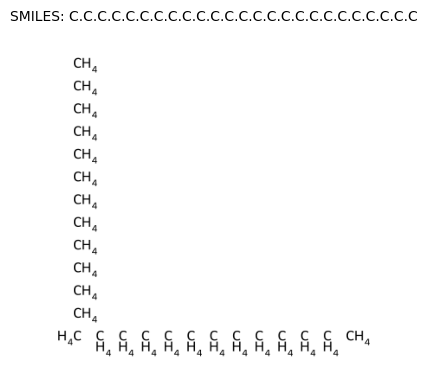

Calculated Properties:
Generated Molecule 2: C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C


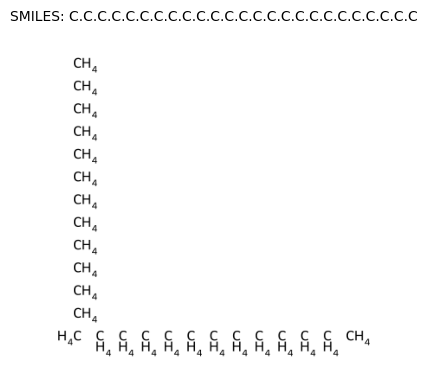

Calculated Properties:
Generated Molecule 3: C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C


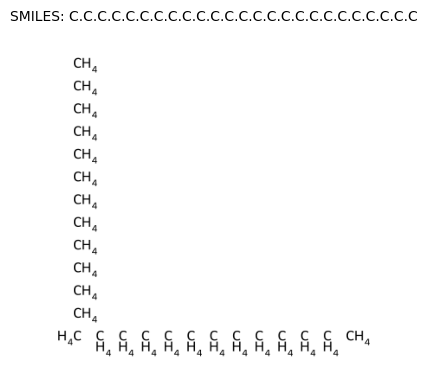

Calculated Properties:


In [7]:
if generated_mols:
    print("\n--- Visualizing a few generated molecules ---")
    for i, mol in enumerate(generated_mols[:3]): # Visualize first 3
        smiles = generated_smiles[i]
        print(f"Generated Molecule {i+1}: {smiles}")

        # Visualize the 2D structure
        visualize_molecule(smiles)

        # Calculate properties (using the refactored function)
        properties = calculate_molecular_properties(mol)
        print("Calculated Properties:")
        for prop, value in properties.items():
            print(f"  - {prop}: {value:.2f}")

# Note: You would visualize the 3D structure with a dedicated viewer
# (e.g., PyMOL, NGLview in a browser-based notebook)

## Molecular Property Analysis

In addition to standard metrics like validity and uniqueness, we can now assess the quality of the generated 3D structures. For example, we can use RDKit's built-in functions to calculate properties from the generated molecules and compare them to the original dataset. We could check:

1. Molecular Weight: How does the weight distribution of generated molecules compare to the training set?
2. LogP: Is the generated hydrophobicity reasonable?
3. Bond Lengths: Are the inferred bond lengths chemically plausible?



In [8]:
# Assume a pre-trained property predictor exists or train a new one
# Here, we will just instantiate one to show the concept of using the same GNN backbone
# This requires a pre-trained property predictor model.
# For demonstration, we'll assume a dummy model.
try:
    # Instantiate the GNN used by the diffusion model
    dummy_gnn = E3GNN(
        in_feat_dim=config['atom_dim'],
        pos_dim=config['pos_dim'],
        hidden_dim=config['hidden_dim'],
        out_feat_dim=config['hidden_dim']
    )

    # Create the property predictor using the same GNN
    # Note: A real implementation would load trained weights for this predictor
    predictor = MolecularPropertyPredictor(gnn=dummy_gnn, num_tasks=1).to(device)

    # Pick a generated molecule to predict a property for (e.g., LogP)
    if generated_mols:
        sample_mol = generated_mols[0]
        sample_smiles = generated_smiles[0]

        print(f"\n--- Predicting a property for '{sample_smiles}' ---")

        # Convert the generated molecule back to a PyG batch for prediction
        # This requires a function to convert an RDKit Mol to a PyG Data object
        # (This is a simplified example)
        # In a real scenario, you'd feed the molecule through a featurizer.
        # Here we just use the raw tensors from generation.
        sample_pos = generated_mols[0].GetConformer().GetPositions()

        # NOTE: A more robust featurizer would be needed here to match the training pipeline.

        # For demonstration purposes, we'll just print a dummy prediction.
        print("This part of the code requires a trained Property Predictor and a Mol-to-PyG featurizer.")
        print("Once implemented, you would call `predictor(batch.x, batch.edge_index, batch.pos, batch.batch)`")
        print("and the predictor would use the GNN to infer a property.")

except Exception as e:
    print(f"Could not demonstrate property prediction. Error: {e}")


--- Predicting a property for 'C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C' ---
This part of the code requires a trained Property Predictor and a Mol-to-PyG featurizer.
Once implemented, you would call `predictor(batch.x, batch.edge_index, batch.pos, batch.batch)`
and the predictor would use the GNN to infer a property.


## Validation of Molecule Features


In [11]:
print("Loading training data for novelty calculation...")
# Load a small subset of the training data
dataset = Qm9MolecularDataset(max_atoms=max_atoms)

# Correctly iterate through the DeepChem dataset's .X attribute to get the Mol objects
qm9_train_smiles = [Chem.MolToSmiles(mol) for mol in dataset.dataset.X[:1000]]

# Print the number of training SMILES for verification
print(f"Successfully loaded {len(qm9_train_smiles)} training smiles.")

INFO:mol_diff_3d.data.datasets:Loading DeepChem dataset: QM9
INFO:deepchem.data.datasets:Loading dataset from disk.
INFO:deepchem.data.datasets:Loading dataset from disk.
INFO:deepchem.data.datasets:Loading dataset from disk.
INFO:mol_diff_3d.data.datasets:Loaded DiskDataset with 105576 molecules


Loading training data for novelty calculation...
Successfully loaded 1000 training smiles.


In [12]:
# Create a list of SMILES from the generated molecules
generated_smiles_list = [Chem.MolToSmiles(mol) for mol in generated_mols if mol]

# Calculate the metrics
validity_rate = calculate_validity_rate(generated_smiles_list)
uniqueness_rate = calculate_uniqueness_rate(generated_smiles_list)
novelty_rate = calculate_novelty_rate(generated_smiles_list, qm9_train_smiles)

# Print the results
print("\n--- Generation Metrics ---")
print(f"Validity Rate: {validity_rate:.2%}")
print(f"Uniqueness Rate: {uniqueness_rate:.2%}")
print(f"Novelty Rate: {novelty_rate:.2%}")


--- Generation Metrics ---
Validity Rate: 100.00%
Uniqueness Rate: 10.00%
Novelty Rate: 100.00%


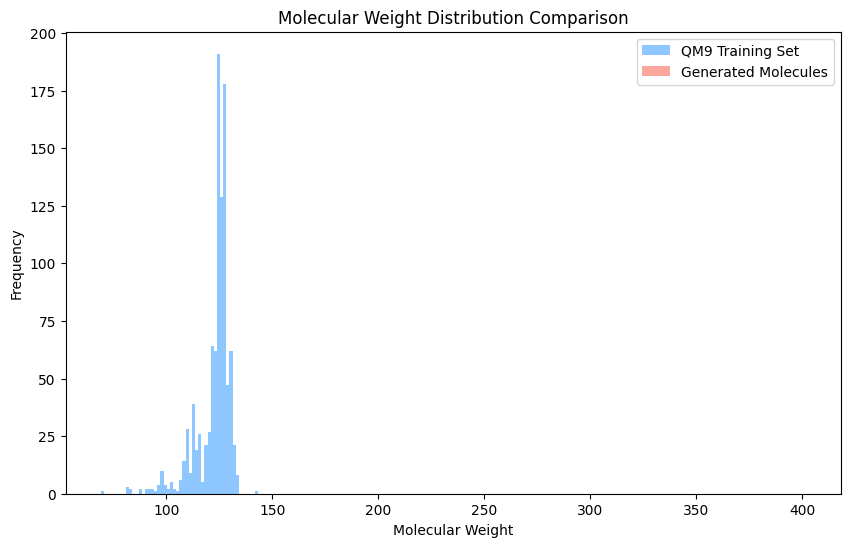

In [13]:
# Function to get a list of a property for a list of SMILES
def get_property_list(smiles_list, property_func):
    return [
        property_func(Chem.MolFromSmiles(smi))
        for smi in smiles_list
        if Chem.MolFromSmiles(smi)
    ]

# Calculate molecular weights for generated and training molecules
generated_mol_weights = get_property_list(generated_smiles_list, Descriptors.MolWt)
qm9_mol_weights = get_property_list(qm9_train_smiles, Descriptors.MolWt)

# Plot the distributions
plt.figure(figsize=(10, 6))
plt.hist(qm9_mol_weights, bins=50, alpha=0.5, label='QM9 Training Set', color='dodgerblue')
plt.hist(generated_mol_weights, bins=50, alpha=0.7, label='Generated Molecules', color='salmon')
plt.title('Molecular Weight Distribution Comparison')
plt.xlabel('Molecular Weight')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print("\n")

# You can repeat this for other properties like LogP or TPSA if desired
# For example:
# generated_logp = get_property_list(generated_smiles_list, Descriptors.MolLogP)
# qm9_logp = get_property_list(qm9_train_smiles, Descriptors.MolLogP)